# SVM

In [1]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import csv
#from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
import nibabel as nib
from nilearn import plotting as plotting
import glob

/opt/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def binaryze_mask(in_file, out_file):
    from nipype.interfaces.fsl.maths import UnaryMaths
    binaryze_mask = UnaryMaths()
    binaryze_mask.inputs.in_file = in_file
    binaryze_mask.inputs.operation = 'bin'
    binaryze_mask.inputs.out_file = out_file
    #print(binaryze_mask.cmdline)
    binaryze_mask.run()
    return out_file

def thrp_mask(in_file, out_file, thr):
    from nipype.interfaces.fsl.maths import Threshold
    thrp_mask = Threshold()
    thrp_mask.inputs.in_file = in_file
    thrp_mask.inputs.thresh = int(thr)
    thrp_mask.inputs.use_robust_range = True
    thrp_mask.inputs.out_file = out_file
    print(thrp_mask.cmdline)
    thrp_mask.run()
    return out_file

In [88]:
os.getcwd()

In [4]:
data_folder = '../20190801'

## Extract data from preprocessed niftis and store them in concatenated numpy arrays

In [5]:
train_subjects = ['SMART019', 'SMART022', 'SMART029']
# Train subject are the manual adjusted
les = glob.glob(os.path.join(data_folder + '/SMART0*/ples_lga_0.3_rmSMART0*.flair_ro_mod.nii'))
les2 = [data_folder + '/{sub}/ples_lga_0.3_rm{sub}.flair_ro.nii.gz'.format(sub=i) for i in train_subjects]
les += les2
train_subjects = [i.split('/')[2] for i in les]
#les2

[True, True, True, True, True]

In [82]:
flairs = [data_folder + '/{sub}/rm{sub}.flair_ro.nii.gz'.format(sub=i) for i in train_subjects]
#flairs

In [83]:
t1s = [data_folder + '/{sub}/anat/{sub}.anat_ro_n4.nii.gz'.format(sub=i) for i in train_subjects]
#t1s

In [90]:
#[os.path.isfile(i) for i in t1s] + [os.path.isfile(i) for i in les] + [os.path.isfile(i) for i in flairs]


In [9]:
#les_thr = [i for i in [thrp_mask(j, '..' + j.strip('.nii') + '_thrp80.nii.gz', 80) for j in les]]

In [10]:
#les_bin = [i for i in [binaryze_mask(j, '..' + j.strip('.nii.gz') + '_thrp80_bin.nii.gz') for j in les_thr]]
les_bin = les

# Open and Concatenate data

In [16]:
t1_values = np.concatenate(tuple([nib.load(i).get_data() for i in t1s]))
flair_values = np.concatenate(tuple([nib.load(i).get_data() for i in flairs]))
les_values = np.concatenate(tuple([nib.load(i).get_data() for i in les_bin]))


In [17]:
t1_values.shape

(960, 256, 256)

In [18]:
t1_values.shape == flair_values.shape == les_values.shape

True

## Organize Data

### ToDo: Normalization

In [91]:
nt1= t1_values
nflair = flair_values

### DataFrame

In [ ]:
df = pd.DataFrame.from_dict({'t1':list(nt1.reshape(-1)), 'flair':list(nflair.reshape(-1)), 'les':list(les_values.reshape(-1))})

### Drop Zeros

In [22]:
df_nonzero = df[(df.t1 != 0 ) & (df.flair != 0)]
df_nonzero = df[(df.t1 >50 ) & (df.flair > 50)]

In [23]:
df_nonzero.head()

,t1,flair,les
1011782,63.022430,53.046741,0.0
1012036,55.360161,161.159485,0.0
1012037,83.749763,97.502846,0.0
1012038,93.459648,50.227985,0.0
1012291,64.315239,222.955093,0.0


### Balance Negatives

In [25]:
len(df_nonzero)

11055729

In [26]:
len(df_nonzero[(df_nonzero.les == 1)])

32402

In [28]:
# Limit negatives to 10 time positives
df_train = df_nonzero[(df_nonzero.les == 1)].append(df_nonzero[(df_nonzero.les == 0)].sample(len(df_nonzero[(df_nonzero.les == 1)])*10))

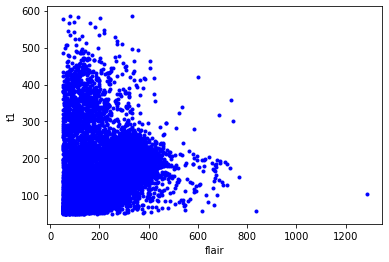

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
sample = df_nonzero.sample(10000)
ax.scatter(sample.flair, sample.t1, marker = '.', c = 'b')
#ax.scatter(train_pos.flair, train_pos.t1, marker = '.', c = 'r' )
#ax.scatter(test_neg.flair, test_neg.t1, marker = 'v', c = 'b')
#ax.scatter(test_pos.flair, test_pos.t1, marker = 'v', c = 'r' )
#ax.scatter(flair_les, t1_les, c='r', marker='^')
ax.set_xlabel('flair')
ax.set_ylabel('t1')
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


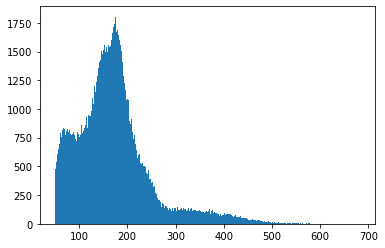

In [30]:
ax = fig.add_subplot(111)
plt.hist(df_train.t1, bins=1000)
ax.set_xlabel('t1')
#ax2 = fig.add_subplot(111)
#plt.hist(df_train.flair, bins=1000)
#ax2.set_xlabel('flair')
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


Text(0.5, 17.200000000000003, 't1')

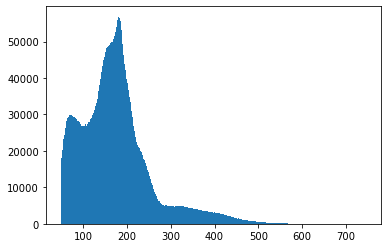

In [31]:
ax = fig.add_subplot(111)
plt.hist(df_nonzero.t1, bins=1000)
ax.set_xlabel('t1')

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after rem

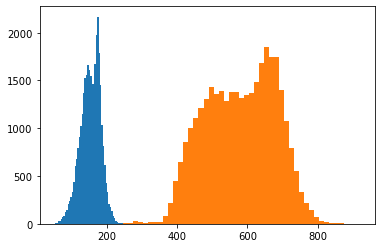

In [32]:
ax = fig.add_subplot(111)
plt.hist(df_train[(df_nonzero.les == 1)].t1, bins=50)
ax.set_xlabel('t1')
ax2 = fig.add_subplot(111)
plt.hist(df_train[(df_nonzero.les == 1)].flair, bins=50)
ax2.set_xlabel('flair')
plt.show()

In [33]:
df_train.les = df_train.les.apply(lambda x: int(x))
df_train.head()

,t1,flair,les
8672632,171.419403,329.313354,1
8673656,165.941376,451.760437,1
8738936,166.636658,386.151001,1
15100308,197.018631,246.613998,1
15100564,205.185745,277.135376,1


In [34]:
# Input is every column but the les
X = df_train[['t1', 'flair']]
y = df_train[['les']]

In [35]:
## Split the dataset into train and test data

In [36]:
from sklearn.model_selection import train_test_split

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [40]:
%%time

from sklearn import svm
svmc = svm.SVC(kernel='linear')
svmc.fit(X_train,y_train)
svmc.predict(X_test)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2h 43min 25s, sys: 524 ms, total: 2h 43min 26s
Wall time: 2h 43min 28s


array([0, 0, 0, ..., 0, 0, 0])

In [44]:
svmc.score(X_test, y_test)

0.9806691449814127

In [46]:
#svmc.accuracy_score(y_train, y_test)

## Building and training the model

In [48]:
%%time

X = df_train[['t1', 'flair']]
y = df_train[['les']]

from sklearn.ensemble import RandomForestClassifier

# Create KNN classifier
rfc = RandomForestClassifier(n_estimators = 100, n_jobs=7)

# Fit the classifier to the data
rfc.fit(X,y)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 1min 40s, sys: 292 ms, total: 1min 41s
Wall time: 25 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=7,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [55]:
## Save Classifier
import joblib

joblib.dump(rfc, 'SVM.pkl')

['SVM.pkl']

## Build Test DataSet

In [50]:
test_subjects = ['SMART007'] #['SMART004', 'SMART007']

In [51]:
#flairs = [data_folder + '/{0}/flair/{0}.flair_ro_n4_2t1Warped_brain.nii.gz'.format(i) for i in test_subjects ] 
flairs = [data_folder + '/{0}/rm{0}.flair_ro.nii.gz'.format(i) for i in test_subjects ] 

In [52]:
t1s = [data_folder + '/{0}/anat/{0}.anat_ro_n4.nii.gz'.format(i) for i in test_subjects ] 

In [64]:
les = [data_folder + '/{sub}/ples_lga_0.3_rm{sub}.flair_ro.nii.gz'.format(sub=i) for i in test_subjects]
#les_thr = [i for i in [thrp_mask(j, '..' + j.strip('.nii') + '_thrp80.nii.gz', 80) for j in les]]
#les_bin = [i for i in [binaryze_mask(j, '..' + j.strip('.nii.gz') + '_thrp80_bin.nii.gz') for j in les_thr]]
t1s = [data_folder + '/{0}/anat/{0}.anat_ro_n4.nii.gz'.format(i) for i in test_subjects ] 

In [67]:
test_t1_values = np.concatenate(tuple([nib.load(i).get_data() for i in t1s]))
test_flair_values = np.concatenate(tuple([nib.load(i).get_data() for i in flairs]))
test_les_values = np.concatenate(tuple([nib.load(i).get_data() for i in les]))

In [68]:
test_les_values.shape

(192, 256, 256)

In [69]:
test_nt1= test_t1_values #/ np.mean(test_t1_values[np.nonzero(test_t1_values)])
test_nflair = test_flair_values #/ np.mean(test_flair_values[np.nonzero(test_flair_values)])

In [70]:
test_df = pd.DataFrame.from_dict({'t1':list(test_nt1.reshape(-1)), 'flair':list(test_nflair.reshape(-1)), 'les':list(test_les_values.reshape(-1))})
#test_df = test_df[(test_df.t1 != 0 ) & (test_df.flair != 0)]

In [71]:
test_df.head()

,t1,flair,les
0,11.178084,0.0,0.0
1,10.626781,0.0,0.0
2,8.489780,0.0,0.0
3,5.300990,0.0,0.0
4,4.238359,0.0,0.0


In [72]:
%%time
prediction = rfc.predict(test_df[['t1', 'flair']])

CPU times: user 1min 34s, sys: 15.6 s, total: 1min 50s
Wall time: 18.4 s


In [73]:
## Add prediction to DataFrame
test_df['les_prediction'] = prediction

In [74]:
test_df.head()

,t1,flair,les,les_prediction
0,11.178084,0.0,0.0,0
1,10.626781,0.0,0.0,0
2,8.489780,0.0,0.0,0
3,5.300990,0.0,0.0,0
4,4.238359,0.0,0.0,0


In [ ]:
len(test_df[(test_df.les == 1.0)])

In [ ]:
len(test_df[(test_df.les_prediction == 1)])

In [ ]:
len(test_df[(test_df.les == test_df.les_prediction) & ((test_df.les ==1)|(test_df.les_prediction == 1))])

## Applying MNI152 Inverse Coregistered White Matter Mask to the prediction

In [75]:
wm_mask = nib.load(data_folder + '/SMART007/MNI152_T1_1mm_Brain_FAST_pve_2_anatcoreg_bin.nii.gz')
test_df['wm_mask'] = wm_mask.get_data().reshape(-1)

In [76]:
len_lga = len(test_df[(test_df.les == 1)])
len_lga

10534

In [77]:
len_pred = len(test_df[(test_df.les_prediction == 1)&(test_df.wm_mask == 1)])
len_pred

7789

In [78]:
len_common = len(test_df[(test_df.les == test_df.les_prediction) & ((test_df.wm_mask == 1)&(test_df.les_prediction == 1))])
len_common

6764

### Plot Intensitites

In [180]:
len(test_df)

12582912

In [183]:
train_pos = df_nonzero[(df_nonzero.les == 1)].sample(n=1000)
train_neg = df_nonzero[(df_nonzero.les == 0)].sample(n=1000)

test_pos = test_df[(test_df.les_prediction == 1)].sample(1000)
test_neg = test_df[(test_df.les_prediction == 0)].sample(1000)

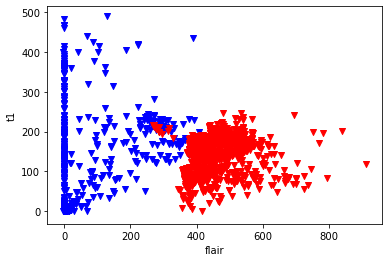

In [184]:
#IND2=np.random.randint(np.shape(t1_tissue)[0], size=flair_les.shape[0])
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(train_neg.flair, train_neg.t1, marker = '.', c = 'b')
#ax.scatter(train_pos.flair, train_pos.t1, marker = '.', c = 'r' )
ax.scatter(test_neg.flair, test_neg.t1, marker = 'v', c = 'b')
ax.scatter(test_pos.flair, test_pos.t1, marker = 'v', c = 'r' )
#ax.scatter(flair_les, t1_les, c='r', marker='^')
ax.set_xlabel('flair')
ax.set_ylabel('t1')
plt.show()

# Save Results

In [80]:
#save_path = '../WhiteMatterHyperintensities/Data/train'
#np.save(save_path + '/t1_tissue.npy', t1_tissue, allow_pickle=True, fix_imports=True)
#np.save(save_path + '/flair_tissue.npy', flair_tissue, allow_pickle=True, fix_imports=True)
#np.save(save_path + '/t1_les.npy', t1_les, allow_pickle=True, fix_imports=True)
#np.save(save_path + '/flair_les.npy', flair_les, allow_pickle=True, fix_imports=True)

## Save NIfTIs

In [79]:
les = test_df['les_prediction'].values.reshape((192, 256, 256))
img = nib.load(data_folder + '/SMART007/rmSMART007.flair_ro.nii.gz')

new_img = nib.Nifti1Image(les, img.affine, img.header)
nib.save(new_img, data_folder + '/SMART007/rmSMART007.flair_ro_SVM_mask.nii')